In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
import numpy as np
import joblib


## 1. Cargar datos y nombrar columnas

In [3]:
cols = [
    'S1','C1',
    'S2','C2',
    'S3','C3',
    'S4','C4',
    'S5','C5',
    'hand'
]

train_path = "poker-hand-training-true.data"
test_path = "poker-hand-testing.data"

train = pd.read_csv(train_path, header=None)
test = pd.read_csv(test_path, header=None)

train.columns = cols
test.columns = cols


In [4]:
test.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


Distribucion:

In [5]:
distribucion = train['hand'].value_counts(normalize=True).sort_index() * 100
distribucion

hand
0    49.952019
1    42.379048
2     4.822071
3     2.051180
4     0.371851
5     0.215914
6     0.143942
7     0.023990
8     0.019992
9     0.019992
Name: proportion, dtype: float64

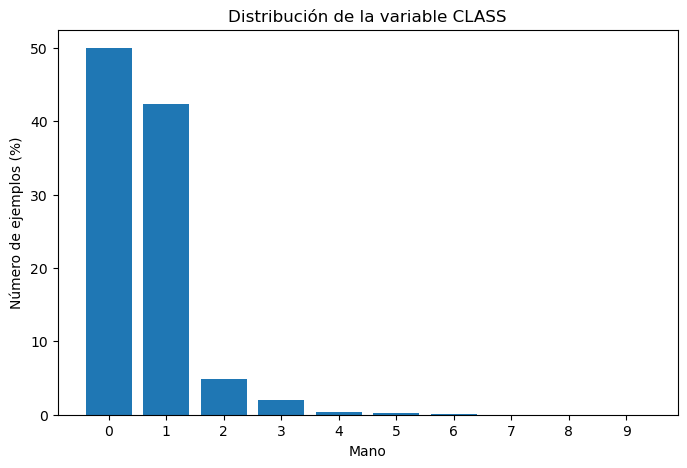

In [6]:
plt.figure(figsize=(8,5))
plt.bar(distribucion.index.astype(str), distribucion.values)
plt.xlabel("Mano")
plt.ylabel("Número de ejemplos (%)")
plt.title("Distribución de la variable CLASS")
plt.show()

## 2. Separar Features y Target

### 2.1 Como la distribución es tan desigual, voy a crear una nueva columna con agrupaciones de manos en "Buenas(2), mediocres(1) y malas(0)" para tener resultados más estables.

In [7]:

def group_hand(h):
    if h in [0, 1]:
        return 0
    if h in [2, 3, 4, 5]:
        return 1
    return 2

train["hand_group"] = train["hand"].apply(group_hand)
test["hand_group"] = test["hand"].apply(group_hand)

X_train = train.drop(["hand", "hand_group"], axis=1)
y_train = train["hand_group"]
X_test = test.drop(["hand", "hand_group"], axis=1)
y_test = test["hand_group"]



## 3. Aplicar Train-Test Split no tiene sentido ya que tenemos separados en dos dataframes nuestro Train y Test de manera predeterminada.

## 4. Aplicar SMOTE para balancear clases raras

In [8]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


Veamos si nos ha nivelado los datos:

In [9]:
y_train.value_counts(), y_train_res.value_counts()


(hand_group
 0    23092
 1     1866
 2       52
 Name: count, dtype: int64,
 hand_group
 2    23092
 0    23092
 1    23092
 Name: count, dtype: int64)

In [10]:
class_counts = y_train_res.value_counts().sort_index()
class_percent = (class_counts / class_counts.sum()) * 100

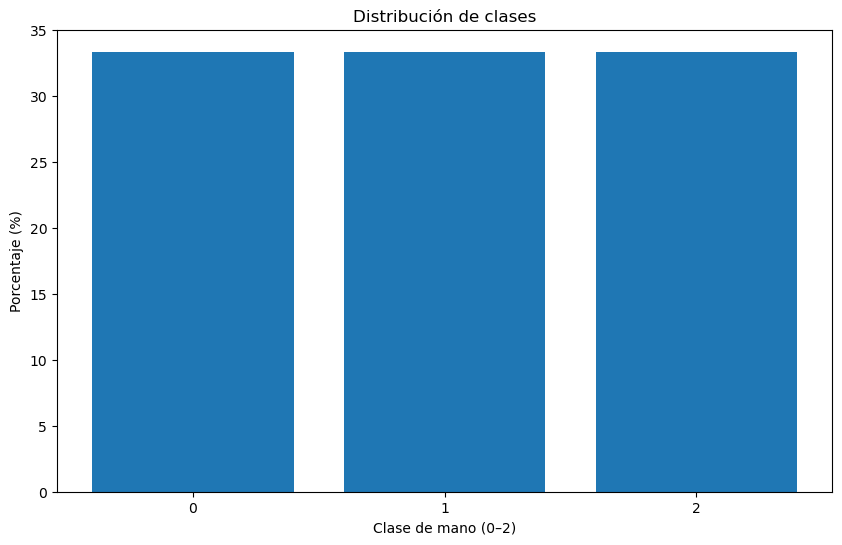

In [11]:
plt.figure(figsize=(10,6))
plt.bar(class_percent.index, class_percent.values)
plt.xlabel('Clase de mano (0–2)')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de clases')
plt.xticks(class_percent.index)
plt.show()

ESTANDARIZACION

In [12]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 5. Entrenar modelos:

KNN

In [13]:
""""
knn = KNeighborsClassifier()
knn.fit(X_train_res_scaled, y_train_res)
y_pred_knn = knn.predict(X_test_scaled)
score_knn = knn.score(X_test, y_test)
score_knn
"""""

'"\nknn = KNeighborsClassifier()\nknn.fit(X_train_res_scaled, y_train_res)\ny_pred_knn = knn.predict(X_test_scaled)\nscore_knn = knn.score(X_test, y_test)\nscore_knn\n'

In [14]:
print(classification_report(y_test, y_pred_knn))

NameError: name 'y_pred_knn' is not defined

REGRESION LOGISTICA

In [ ]:
log_reg = LogisticRegression(max_iter=2000, n_jobs=-1)
log_reg.fit(X_train_res_scaled, y_train_res)
y_pred_log = log_reg.predict(X_test_scaled)

accuracy_score(y_test, y_pred_log)

0.533386

In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.92      0.56      0.70    923707
           1       0.08      0.20      0.11     74624
           2       0.00      0.22      0.00      1669

    accuracy                           0.53   1000000
   macro avg       0.33      0.32      0.27   1000000
weighted avg       0.86      0.53      0.65   1000000



 ÁRBOL DE DECISIÓN

In [18]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res_scaled, y_train_res)
y_pred_tree = dt.predict(X_test_scaled)
accuracy_score(y_test, y_pred_tree)

0.798336

In [16]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89    923707
           1       0.12      0.26      0.16     74624
           2       0.01      0.03      0.01      1669

    accuracy                           0.80   1000000
   macro avg       0.35      0.38      0.35   1000000
weighted avg       0.87      0.80      0.83   1000000



In [ ]:
y_pred_tree

array([0, 0, 0, ..., 0, 0, 0])

## 6. ENSAMBLE

BAGGING

In [ ]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)

bagging.fit(X_train_res_scaled, y_train_res)
y_pred_bag = bagging.predict(X_test_scaled)


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\Users\andre\anaconda3\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 608, in run
    self.flag_executor_shutting_down()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 826, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 836, in kill_workers
    kill_process_tree(p)
    ~~~~~~~~~~~~~~~~~^^^
  File "c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\backend\utils.py", line 19, in kill_process_tree
    _kill_process_tree_with_psutil(process)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^

In [ ]:
y_pred_bag

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test, y_pred_bag)

0.873424

RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
rf.score(X_test, y_test)

0.871108

In [ ]:
y_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    923707
           1       0.24      0.12      0.16     74624
           2       0.02      0.01      0.01      1669

    accuracy                           0.90   1000000
   macro avg       0.40      0.37      0.37   1000000
weighted avg       0.88      0.90      0.89   1000000



ADA BOOST

In [ ]:
base_tree = DecisionTreeClassifier(
    max_depth=3,        
    random_state=42
)
ada_clf = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train_res_scaled, y_train_res)
y_pred_ada = ada_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77    923707
           1       0.10      0.29      0.15     74624
           2       0.00      0.16      0.00      1669

    accuracy                           0.63   1000000
   macro avg       0.35      0.37      0.31   1000000
weighted avg       0.87      0.63      0.72   1000000



GRADIENT BOOSTING

In [ ]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,         
    subsample=0.8,       
    random_state=42
)

gb_clf.fit(X_train_res_scaled, y_train_res)
y_pred_gb = gb_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84    923707
           1       0.14      0.42      0.21     74624
           2       0.00      0.09      0.01      1669

    accuracy                           0.73   1000000
   macro avg       0.36      0.42      0.35   1000000
weighted avg       0.89      0.73      0.79   1000000



In [ ]:
gb_clf.score(X_test, y_test)

0.077186

## El mejor modelo hasta ahora ha sido el Random Forest. Vamos a tunear parámetros:

RANDOM SEARCH

In [ ]:
# Distribuciones de parámetros
param_dist = {
    'n_estimators': np.arange(200, 600, 50),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': np.arange(2, 15),
    'min_samples_leaf': np.arange(1, 6),
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    cv=3,
    verbose=2,
    n_jobs=1,         
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train_res_scaled, y_train_res)

print("Mejores hyperparámetros:", random_search.best_params_)
print("Mejor accuracy en CV:", random_search.best_score_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=5, min_samples_split=13, n_estimators=500; total time=   5.8s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=5, min_samples_split=13, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=5, min_samples_split=13, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   4.8s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   

In [ ]:
import joblib
best_rf = random_search.best_estimator_
joblib.dump((best_rf, scaler), "best_model.pkl")

['best_model.pkl']

In [ ]:
best_rf = random_search.best_estimator_
joblib.dump((best_rf, scaler), "best_model.pkl")

['best_model.pkl']